In [13]:
from utils.tools import dotdict
import torch,time

import matplotlib.pyplot as plt
%matplotlib inline
args = dotdict()
args.is_training=1
args.train_only=True
 
# args.model = 'Linear'
args.model = 'MLinear'
args.data = 'ETTh2' # data
args.root_path = './dataset/NMP/' # root path of data file
args.data_path = 'ETTh2.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; 
args.target = 'OT'
args.freq = 'h'
args.checkpoints = './informer_checkpoints'

# forecasting task
args.seq_len = 32 # input sequence length of Informer encoder
args.label_len = 31 # start token length of Informer decoder
args.pred_len = 5 # prediction sequence length
feature_dim=7
# Formers 
args.embed_type=0

args.enc_in = feature_dim # encoder input size
args.dec_in = feature_dim# decoder input size
args.c_out = feature_dim # output size
args.hidden_size =256 

# DLinear
args.individual=False 
args.d_model=512
args.n_heads=8
args.e_layers=2
args.d_layers=1
args.d_ff=2048
args.moving_avg=25
args.factor=1
args.distil=True
args.dropout = 0.05 
args.embed = 'timeF'
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.do_predict=False

# optimization
args.num_workers=0
args.itr = 1
args.train_epochs = 200
args.batch_size = 256
args.patience = 5
args.learning_rate = 0.0001
args.des='Exp'
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training
args.model_id=time.strftime("%Y-%m-%d_%H_%M_%S", time.localtime())+ '__'+args.model+'_feature_dim^'+str(args.enc_in)+'_hidden_size^'+str(args.hidden_size)+'_pred_len^'+str(args.pred_len)+'_batch_size^'+str(args.batch_size)+'_'
# GPU
args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0
args.use_multi_gpu = False
args.devices = '0,1,2,3'
args.test_flop=False

print('Args in experiment:')
print(args)

Args in experiment:
{'is_training': 1, 'train_only': True, 'model': 'MLinear', 'data': 'ETTh2', 'root_path': './dataset/NMP/', 'data_path': 'ETTh2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 32, 'label_len': 31, 'pred_len': 5, 'embed_type': 0, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'hidden_size': 256, 'individual': False, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'moving_avg': 25, 'factor': 1, 'distil': True, 'dropout': 0.05, 'embed': 'timeF', 'activation': 'gelu', 'output_attention': False, 'do_predict': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 200, 'batch_size': 256, 'patience': 5, 'learning_rate': 0.0001, 'des': 'Exp', 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'model_id': '2023-03-29_15_06_30__MLinear_feature_dim^7_hidden_size^256_pred_len^5_batch_size^256_', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'test_flop': False}


In [14]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
if args.use_gpu and args.use_multi_gpu:
    args.dvices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [15]:
# from data_provider.data_factory import data_provider
from data_provider.data_make import data_provider
from data_provider.data_make import data_make

from exp.exp_basic import Exp_Basic
from models import Informer, Autoformer, Transformer, DLinear, Linear, NLinear,MLinear
from utils.tools import EarlyStopping, adjust_learning_rate, visual, test_params_flop
from utils.metrics import metric

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import os
import time

import warnings
import matplotlib.pyplot as plt
import numpy as np

def quatProduct(q1s, q2s):
    q1s=q1s.cpu()
    q2s=q2s.cpu()
    errors=torch.tensor([0])
    # print(errors.shape)
    for j in range(q1s.shape[0]):
        q1=q1s[j]
        q2=q2s[j]
        r1 = q1[3]
        r2 = q2[3]
        v1 = torch.tensor([q1[0], q1[1], q1[2]])
        v2 = torch.tensor([-q2[0], -q2[1], -q2[2]])
        r = r1 * r2 - torch.dot(v1, v2)
        # print(type(r))
        error=2*torch.arccos(r)/6
        # print(error)
        error=torch.tensor([error])
        # print(error)
        errors=torch.cat((error,errors),0)
 
    error=torch.mean(errors)
    # print(error)

    # print(error)
    return error.to('cuda:0')
warnings.filterwarnings('ignore')

class Exp_Main(Exp_Basic):
    def __init__(self, args):
        super(Exp_Main, self).__init__(args)
        data_make(args)

    def _build_model(self):
        model_dict = {
            'Autoformer': Autoformer,
            'Transformer': Transformer,
            'Informer': Informer,
            'DLinear': DLinear,
            'NLinear': NLinear,
            'Linear': Linear,
            'MLinear': MLinear,
        }
        model = model_dict[self.args.model].Model(self.args).float()

        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        # criterion = nn.MSELoss()
        criterion = nn.MSELoss()
       
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if 'Linear' in self.args.model:
                            outputs = self.model(batch_x)
                        else:
                            if self.args.output_attention:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                            else:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if 'Linear' in self.args.model:
                        outputs = self.model(batch_x)
                    else:
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                # outputs = outputs[:, :, f_dim:]
                # batch_y = batch_y[:, :, f_dim:].to(self.device)
                # pred = outputs.detach().cpu()
                # true = batch_y.detach().cpu()

                loss1 = criterion(outputs[:,:,:3], batch_y[:,:,:3])
                loss2 = criterion(outputs[:,:,3:], batch_y[:,:,3:])
                # loss3 = criterion(outputs[:,:,3:], batch_y[:,:,3:])
                # # loss =  torch.sqrt(loss1)
                # # loss2 =  torch.sqrt(loss2)
                loss=loss1 + loss2
                # loss = criterion(outputs,batch_y)
                loss= loss.cpu()

                total_loss.append(loss)
        total_loss = np.average(total_loss)
        # self.model.train()
        return total_loss

    def train(self, setting):

        train_data, train_loader = self._get_data(flag='train')
        if not self.args.train_only:
            vali_data, vali_loader = self._get_data(flag='val')
            test_data, test_loader = self._get_data(flag='test')

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()

        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []

            self.model.train()
            epoch_time = time.time()
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()
                batch_x = batch_x.float().to(self.device)

                batch_y = batch_y.float().to(self.device)
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if 'Linear' in self.args.model:
                            outputs = self.model(batch_x)
                        else:
                            if self.args.output_attention:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                            else:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                        f_dim = -1 if self.args.features == 'MS' else 0
                        outputs = outputs[:, -self.args.pred_len:, f_dim:]
                        batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)


                        loss = criterion(outputs, batch_y)
                        train_loss.append(loss.item())
                else:
                    if 'Linear' in self.args.model:
                            outputs = self.model(batch_x)
                    else:
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                            
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark, batch_y)
                    # print(outputs.shape,batch_y.shape)
                    f_dim = -1 if self.args.features == 'MS' else 0
                    # print(outputs.shape)
                    # print(batch_y.shape)
                    outputs = outputs[:, -self.args.pred_len:, f_dim:]
                    batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                    # outputs = outputs[:, :, f_dim:]
                    # batch_y = batch_y[:, :, f_dim:].to(self.device)
                    # loss1 = criterion(outputs[:,3:], batch_y[:,3:])
                    # loss = criterion(outputs,batch_y)
                    loss1 = criterion(outputs[:,:,:3], batch_y[:,:,:3])
                    loss2 = criterion(outputs[:,:,3:], batch_y[:,:,3:])
                    # loss2 = criterion(outputs[:,:,[3]], batch_y[:,:,[3]])
                    # # loss =  torch.sqrt(loss1)
                    # # loss2 =  torch.sqrt(loss2)
                    loss=loss1 +loss2
                    train_loss.append(loss.item())

                if (i + 1) % 100 == 0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * ((self.args.train_epochs - epoch) * train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()

                if self.args.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()

            print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(train_loss)
            if not self.args.train_only:
                vali_loss = self.vali(vali_data, vali_loader, criterion)
                test_loss = self.vali(test_data, test_loader, criterion)

                print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                    epoch + 1, train_steps, train_loss, vali_loss, test_loss))
                early_stopping(vali_loss, self.model, path)
            else:
                print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f}".format(
                    epoch + 1, train_steps, train_loss))
                early_stopping(train_loss, self.model, path)

            if early_stopping.early_stop:
                print("Early stopping")
                break

            adjust_learning_rate(model_optim, epoch + 1, self.args)

        best_model_path = path + '/' + 'checkpoint.pth'
        torch.save(self.model.state_dict(), best_model_path)
        # self.model.load_state_dict(torch.load(best_model_path))

        return self.model

    def test(self, setting, test=0):
        test_data, test_loader = self._get_data(flag='test')
        
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load('./informer_checkpoints/' + setting+'/checkpoint.pth'))
            # self.model=torch.load('a.pt')

        preds = []
        trues = []
        inputx = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if 'Linear' in self.args.model:
                            outputs = self.model(batch_x)
                        else:
                            if self.args.output_attention:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                            else:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if 'Linear' in self.args.model:
                            outputs = self.model(batch_x)
                    else:
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]

                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -1 if self.args.features == 'MS' else 0
                # print(outputs.shape,batch_y.shape)
                # outputs = outputs[:, -self.args.pred_len:, f_dim:]
                # batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                

                # batch_y = batch_y[:, -1, f_dim:].to(self.device)
                outputs = outputs[:,-self.args.pred_len:, f_dim:]
                batch_y = batch_y[:,-self.args.pred_len:, f_dim:].to(self.device)
                # print('s',outputs.shape, batch_y.shape)
                outputs = outputs.detach().cpu().numpy()
                batch_y = batch_y.detach().cpu().numpy()
           
                pred = outputs[:,:,:]  # outputs.detach().cpu().numpy()  # .squeeze()
                true = batch_y[:,:,:]  # batch_y.detach().cpu().numpy()  # .squeeze()
                # print(pred.shape, true.shape)
                preds.append(pred)
                trues.append(true)
                inputx.append(batch_x.detach().cpu().numpy())
                # if i % 10 == 0:
                #     input = batch_x.detach().cpu().numpy()
                #     # gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
                #     # pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
                #     gt = np.concatenate((input[0, :, 1], true[0, :, 1]), axis=0)
                #     pd = np.concatenate((input[0, :, 1], pred[0, :, 1]), axis=0)
                #     visual(gt, pd, os.path.join(folder_path, str(i) + '1.jpg'))
                #     gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
                #     pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
                #     visual(gt, pd, os.path.join(folder_path, str(i) + '-1.jpg'))
                #     gt = np.concatenate((input[0, :, 0], true[0, :, 0]), axis=0)
                #     pd = np.concatenate((input[0, :, 0], pred[0, :, 0]), axis=0)
                #     visual(gt, pd, os.path.join(folder_path, str(i) + '.jpg'))

        if self.args.test_flop:
            test_params_flop((batch_x.shape[1],batch_x.shape[2]))
            exit()
        preds = np.array(preds)
        trues = np.array(trues)
        inputx = np.array(inputx)

        # preds = preds.reshape( preds.shape[-2], preds.shape[-1])
        # trues = trues.reshape( trues.shape[-2], trues.shape[-1])
        print(preds.shape, trues.shape)
        # print(preds,trues)
        inputx = inputx.reshape(-1, inputx.shape[-2], inputx.shape[-1])

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe, rse, corr = metric(preds, trues)
        print('mse:{}, mae:{}'.format(mse, mae))
        f = open("result.txt", 'a')
        f.write(setting + "  \n")
        f.write('mse:{}, mae:{}, rse:{}, corr:{}'.format(mse, mae, rse, corr))
        f.write('\n')
        f.write('\n')
        f.close()

        # np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe,rse, corr]))
        np.save(folder_path + 'pred.npy', preds)
        np.save(folder_path + 'true.npy', trues)
        # np.save(folder_path + 'x.npy', inputx)
        return

    def predict(self, setting, load=False):
        pred_data, pred_loader = self._get_data(flag='pred')

        if load:
            path = os.path.join(self.args.checkpoints, setting)
            best_model_path = path + '/' + 'checkpoint.pth'
            self.model.load_state_dict(torch.load(best_model_path))

        preds = []

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros([batch_y.shape[0], self.args.pred_len, batch_y.shape[2]]).float().to(batch_y.device)
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if 'Linear' in self.args.model:
                            outputs = self.model(batch_x)
                        else:
                            if self.args.output_attention:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                            else:
                                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if 'Linear' in self.args.model:
                        outputs = self.model(batch_x)
                    else:
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                pred = outputs.detach().cpu().numpy()  # .squeeze()
                preds.append(pred)

        preds = np.array(preds)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        # if (pred_data.scale):
        #     preds = pred_data.inverse_transform(preds)
        
        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        np.save(folder_path + 'real_prediction.npy', preds)
        # pd.DataFrame(np.append(np.transpose([pred_data.future_dates]), preds[0], axis=1), columns=pred_data.cols).to_csv(folder_path + 'real_prediction.csv', index=False)

        return


In [16]:
Exp = Exp_Main

if args.is_training:
    for ii in range(args.itr):
        # setting record of experiments
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des, ii)

        exp = Exp(args)  # set experiments
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        smodel=exp.train(setting)
        # torch.save(smodel, 'a.pt')
        
        exp.test(setting)
        # exp.predict(setting, True)
        
        # if not args.train_only:
        #     print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        #     exp.test(setting)


        # if args.do_predict:
        #     print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        #     exp.predict(setting, True)

        torch.cuda.empty_cache()

Use GPU: cuda:0


KeyboardInterrupt: 

In [ ]:
Exp = Exp_Main
exp = Exp(args) 
exp.test(setting,1)

Use GPU: cuda:0
(223813, 32, 7) (223813, 36, 7) (223813, 32, 1) (223813, 36, 1)
loading model
(5595, 4, 5, 4) (5595, 4, 5, 4)
mse:0.00015227723633870482, mae:0.003917630761861801


In [ ]:

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')
print(preds.shape)

(765, 4, 5, 4)


In [ ]:

def make_prediction(exp, setting,pred_data):
    path = os.path.join(exp.args.checkpoints, setting)
    best_model_path = path+'/'+'checkpoint.pth'
    # best_model_path = './informer_checkpoints/'
    exp.model.load_state_dict(torch.load(best_model_path))
    exp.model.eval()     
    batch_x = pred_data.float().to(exp.device)
    outputs = exp.model(batch_x)
    return outputs




In [ ]:
prediction=make_prediction(exp, setting,x)
prediction.shape

NameError: name 'x' is not defined

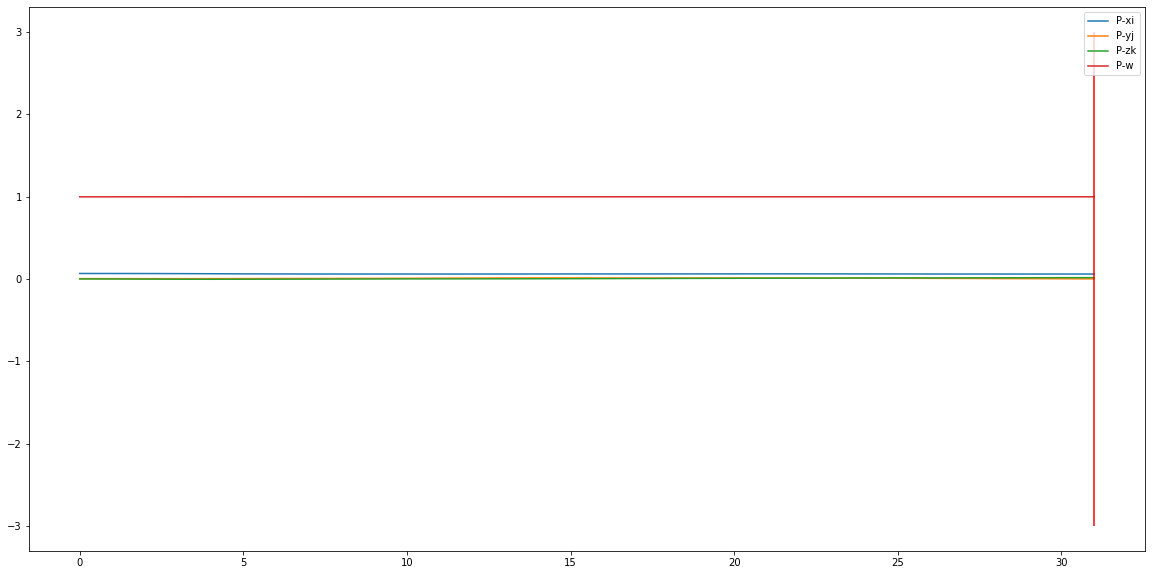

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
plt.plot(nx[0,:,0],label='P-xi')
plt.plot(nx[0,:,1],label='P-yj')
plt.plot(nx[0,:,2],label='P-zk')
plt.plot(nx[0,:,3],label='P-w')

# plt.plot(nx[0,:,9],label='P-w')
# plt.plot(nx[0,:,10],label='P-x')
# plt.plot(nx[0,:,11],label='P-y')
# plt.plot(nx[0,:,12],label='P-z')
# plt.plot(x2[0,:,6],label='t-x',color='g')
# plt.plot(x2[0,:,6],label='t-x',color='g')
plt.vlines(31, -3, 3,color="red")
plt.legend()
plt.show()

In [ ]:
#position

plt.figure(figsize=(20,10))
plt.plot(nx[0,:,0],label='P-xi')
plt.plot(nx[0,:,1],label='P-yj')
plt.plot(nx[0,:,2],label='P-zk')
plt.plot(nx[0,:,3],label='P-w')
# plt.plot(nx[0,:,9],label='P-w')
# plt.plot(nx[0,:,10],label='P-x')
# plt.plot(nx[0,:,11],label='P-y')
# plt.plot(nx[0,:,12],label='P-z')
plt.plot(x2[0,:,0],label='T-xi')
plt.plot(x2[0,:,1],label='T-yj')
plt.plot(x2[0,:,2],label='T-zk')
plt.plot(x2[0,:,3],label='T-w')

plt.plot(nx[0,:82,2]-x2[0,:82,2],label='diff-zk')

# plt.plot(x2[0,:,9],label='P-w')
# plt.plot(x2[0,:,10],label='P-x')
# plt.plot(x2[0,:,11],label='P-y')
# plt.plot(x2[0,:,12],label='P-z')
# plt.plot(x2[0,:,6],label='t-x',color='g')
# plt.plot(x2[0,:,6],label='t-x',color='g')
plt.vlines(32, -3, 3,color="red")
plt.legend()
plt.ylim(-0.1,0.1)
plt.show()

NameError: name 'nx' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:

s=9
print(nx.shape)
# for quat in nx[0]:
    # print(np.linalg.norm(quat))
    # quat=quat/np.linalg.norm(quat)
    # print(np.linalg.norm(quat))
    
plt.figure(figsize=(20,10))
plt.ylim(-0.5,0.5)
# plt.plot(nx[0,:,0],label='P-xi')
# plt.plot(nx[0,:,1],label='P-yj')
# plt.plot(nx[0,:,2],label='P-zk')
plt.plot(nx[0,:,9-s],label='P-w')
plt.plot(nx[0,:,10-s],label='P-x')
plt.plot(nx[0,:,11-s],label='P-y')
plt.plot(nx[0,:,12-s],label='P-z')
# plt.plot(x2[0,:,0],label='T-xi')
# plt.plot(x2[0,:,1],label='T-yj')
# plt.plot(x2[0,:,2],label='T-zk')
plt.plot(x2[0,:,9-s],label='T-w')
plt.plot(x2[0,:,10-s],label='T-x')
plt.plot(x2[0,:,11-s],label='T-y')
plt.plot(x2[0,:,12-s],label='T-z')
# plt.plot(x2[0,:,6],label='t-x',color='g')
# plt.plot(x2[0,:,6],label='t-x',color='g')
plt.vlines(31, -3, 3,color="red")
plt.legend()
plt.show()

NameError: name 's' is not defined

## 四元数误差计算

In [ ]:
Exp = Exp_Main
exp = Exp(args) 
setting='2023-03-29_10_27_00__MLinear_feature_dim^7_hidden_size^256_pred_len^5_batch_size^4__MLinear_ETTh2_ftM_sl32_ll31_pl5_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'

Use GPU: cuda:0
(30629, 32, 7) (30629, 36, 7) (30629, 32, 1) (30629, 36, 1)


In [ ]:
def quatDivision(q1, q2):
    q1=q1/np.linalg.norm(q1)
    r1 = q1[3]
    r2 = q2[3]
    v1 = np.array([q1[0], q1[1], q1[2]])
    v2 = np.array([-q2[0], -q2[1], -q2[2]])

    r = r1 * r2 - np.dot(v1, v2)
    v = r1 * v2 + r2 * v1 + np.cross(v1, v2)
    q = np.array([ v[0], v[1], v[2],r])
    return q
def quatProduct(q1, q2):
    q1=q1/np.linalg.norm(q1)
    r1 = q1[3]
    r2 = q2[3]
    v1 = np.array([q1[0], q1[1], q1[2]])
    v2 = np.array([q2[0], q2[1], q2[2]])

    r = r1 * r2 - np.dot(v1, v2)
    v = r1 * v2 + r2 * v1 + np.cross(v1, v2)
    q = np.array([ v[0], v[1], v[2],r])
    return q
def dot_product_angle(v1, v2):
    v1=v1[:3]
    v2=v2[:3]
    if np.array_equal(v1, v2):
        return 0.0
    if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
        print("Zero magnitude vector!")
    else:
        vector_dot_product = np.dot(v1, v2)
        arccos = np.arccos(vector_dot_product / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        angle = np.degrees(arccos)
        return angle
    return 0
def angle_between_vectors(v1, v2):
    """计算两个向量之间的夹角，返回值为角度"""
    if np.any(np.isnan(v1)) or np.any(np.isnan(v2)):
        return np.nan
    elif np.array_equal(v1, v2):
        return 0.0
    else:
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        cos_theta = np.clip(cos_theta, -1.0, 1.0)  # 将余弦值截取到[-1, 1]的范围内
        theta = np.arccos(cos_theta)
        return np.degrees(theta)





### Diff quat

In [ ]:
e=[]
v=[]
# setting='2023-03-29_08_28_15__MLinear_feature_dim^7_hidden_size^256_pred_len^5_batch_size^4__MLinear_ETTh2_ftM_sl32_ll31_pl5_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
filedir='./dataset/NMP/'
iter=10
for f in os.listdir(filedir)[:]:  
    if 'Bamboo' not in f:
        continue
    df_raw = pd.read_csv(filedir+f)
    # df_raw = pd.read_csv('./dataset/NMP/trimmed_Bamboo_150.csv')
    quat_data=df_raw[['i', 'j', 'k','w']].values
    # cols_data=df_raw[['di', 'dj', 'dk','dw']].values.reshape(1,-1,4)
    cols_data=df_raw[['x','z','y','di', 'dj', 'dk','dw']].values.reshape(1,-1,7)
    batch_x=torch.from_numpy(cols_data[:,:32,:]).float().to(exp.device)
    for i in range(iter):  
        prediction=make_prediction(exp, setting,batch_x[:,:32,:])[:,-5:]
        batch_x=torch.cat((batch_x,prediction),axis=1)

    pred_x=batch_x.detach().cpu().numpy()[:,32:,3:] #.squeeze()
    true_x=quat_data[32:pred_x.shape[1]+32,:]
    pred_x=pred_x.squeeze()

    # print(pred_x.shape,true_x.shape)

    pred_x[0]=true_x[0]
    for j in range(pred_x.shape[0]-1):
        pred_x[j+1]=quatProduct(pred_x[j+1],pred_x[j])

    for i in range(pred_x.shape[0]):
        error_quat=quatDivision(true_x[i],pred_x[i])
        error_angle=2*np.arccos(error_quat[3])
        # error_vector=dot_product_angle(true_x[i],pred_x[i])
        error_vector=angle_between_vectors(true_x[i],pred_x[i])
        # print(error_vector)
        e.append(error_angle)
        v.append(error_vector)
e=np.array(e)
v=np.array(v)
    # e.append(angle)
print(e.mean(),e.std())
print(v.mean(),v.std())

0.8699934985572851 0.6801600520701918
22.20711499613311 21.190020445147955


### quat error

In [ ]:
e=[]
v=[]
setting='2023-03-28_22_13_02__Linear_feature_dim4_hidden_size256_pred_len5_batch_size4__Linear_ETTh2_ftM_sl32_ll31_pl5_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
filedir='./dataset/NMP/'
iter=10
for f in os.listdir(filedir)[:]:  
    if 'Bamboo' not in f:
        continue
    df_raw = pd.read_csv(filedir+f)
    # df_raw = pd.read_csv('./dataset/NMP/trimmed_Bamboo_150.csv')
    quat_data=df_raw[['i', 'j', 'k','w']].values
    cols_data=df_raw[['i', 'j', 'k','w']].values.reshape(1,-1,4)
    batch_x=torch.from_numpy(cols_data[:,:32,:]).float().to(exp.device)
    for i in range(iter):  
        prediction=make_prediction(exp, setting,batch_x[:,:32,:])[:,-5:]
        batch_x=torch.cat((batch_x,prediction),axis=1)

    pred_x=batch_x.detach().cpu().numpy()[:,32:,:] #.squeeze()
    true_x=quat_data[32:pred_x.shape[1]+32,:]
    pred_x=pred_x.squeeze()

    # print(pred_x.shape,true_x.shape)

    # pred_x[0]=true_x[0]
    # for j in range(pred_x.shape[0]-1):
    #     pred_x[j+1]=quatProduct(pred_x[j+1],pred_x[j])

    for i in range(pred_x.shape[0]):
        error_quat=quatDivision(true_x[i],pred_x[i])
        
        error_angle=2*np.arccos(error_quat[3])
        if np.any(np.isnan(error_angle)):
            error_angle=0
        # print(error_angle)
        # error_vector=dot_product_angle(true_x[i],pred_x[i])
        error_vector=angle_between_vectors(true_x[i],pred_x[i])
        # print(error_vector)
        e.append(error_angle)
        v.append(error_vector)
e=np.array(e)
v=np.array(v)
    # e.append(angle)
print(e.mean(),e.std())
print(v.mean(),v.std())

2.6683016396921184 1.5385490270630895
75.72086320925462 45.638410770320256


### plot

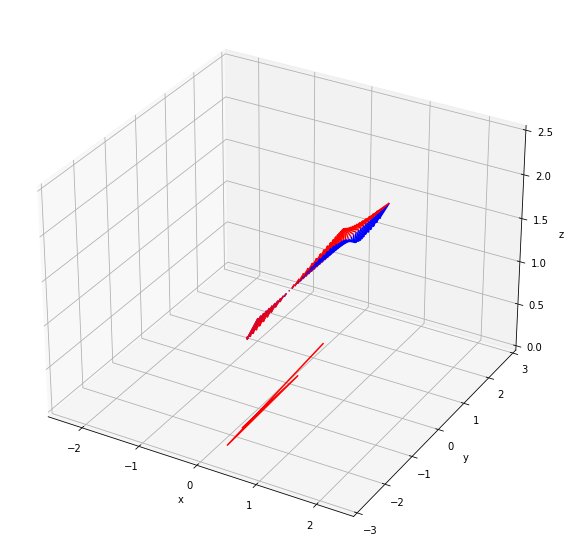

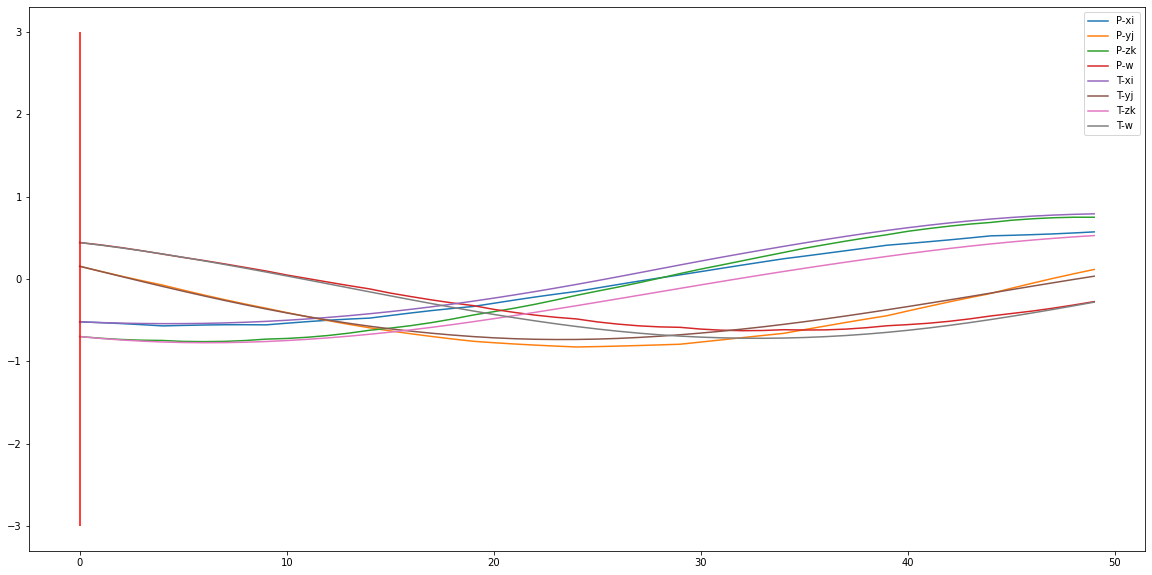

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(10,10))
#创建3D坐标系
ax = fig.gca(projection='3d')
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-3,3)
ax.set_zlim(0,2.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for i in range(pred_x.shape[0]):
        ax.quiver(0,i*0.1-1,1,pred_x[i][0],pred_x[i][1],pred_x[i][2],length=pred_x[i][3], arrow_length_ratio=0.1,color='b')
        ax.quiver(0,i*0.1-1,1,true_x[i][0],true_x[i][1],true_x[i][2],length=true_x[i][3], arrow_length_ratio=0.1,color='r')
# plt.legend()
ax.plot(pred_x[0], pred_x[1],pred_x[2], label='xyz',c='r')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(pred_x[:,0],label='P-xi')
plt.plot(pred_x[:,1],label='P-yj')
plt.plot(pred_x[:,2],label='P-zk')
plt.plot(pred_x[:,3],label='P-w')

plt.plot(true_x[:,0],label='T-xi')
plt.plot(true_x[:,1],label='T-yj')
plt.plot(true_x[:,2],label='T-zk')
plt.plot(true_x[:,3],label='T-w')

plt.vlines(0, -3, 3,color="red")
plt.legend()
# plt.ylim(-0.1,0.1)
plt.show()

## 7维数据误差计算

In [ ]:
Exp = Exp_Main
exp = Exp(args) 
setting='2023-03-29_08_28_15__MLinear_feature_dim^7_hidden_size^256_pred_len^5_batch_size^4__MLinear_ETTh2_ftM_sl32_ll31_pl5_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'

Use GPU: cuda:0
(30629, 32, 7) (30629, 36, 7) (30629, 32, 1) (30629, 36, 1)


In [ ]:
e=[]
v=[]
e_d=[]
filedir='./dataset/NMP/'
iter=10
for f in os.listdir(filedir)[:]:  
    if 'Bamboo' not in f:
        continue
    df_raw = pd.read_csv(filedir+f)
    # df_raw = pd.read_csv('./dataset/NMP/trimmed_Bamboo_150.csv')
    quat_data=df_raw[['i', 'j', 'k','w']].values
    position_data=df_raw[['x','z','y']].values
    # cols_data=df_raw[['di', 'dj', 'dk','dw']].values.reshape(1,-1,4)
    cols_data=df_raw[['x','z','y','di', 'dj', 'dk','dw']].values.reshape(1,-1,7)
    batch_x=torch.from_numpy(cols_data[:,:32,:]).float().to(exp.device)
    for i in range(iter):  
        prediction=make_prediction(exp, setting,batch_x[:,:32,:])[:,-5:]
        batch_x=torch.cat((batch_x,prediction),axis=1)

    pred_x=batch_x.detach().cpu().numpy()[:,32:,3:] #.squeeze()

    true_x=quat_data[32:pred_x.shape[1]+32,:]
    true_position=position_data[32:pred_x.shape[1]+32,:]
    pred_x=pred_x.squeeze()

    

    # print(pred_x.shape,true_x.shape)
    #-------------quat------------------
    pred_x[0]=true_x[0]
    for j in range(pred_x.shape[0]-1):
        pred_x[j+1]=quatProduct(pred_x[j+1],pred_x[j])
    for i in range(pred_x.shape[0]):
        error_quat=quatDivision(true_x[i],pred_x[i])
        error_angle=2*np.arccos(error_quat[3])
        # error_vector=dot_product_angle(true_x[i],pred_x[i])
        error_vector=angle_between_vectors(true_x[i],pred_x[i])
        # print(error_vector)
        e.append(error_angle)
        v.append(error_vector)
    pred_position=batch_x.detach().cpu().numpy()[:,32:,:3]
    pred_position=pred_position.squeeze()
    #-------------position------------------
    for i in range(true_position.shape[0]):
        d = np.sqrt(np.sum((true_position[i] - pred_position[i]) ** 2))*100
        e_d.append(d)

e=np.array(e)
v=np.array(v)
e_d=np.array(e_d)
    # e.append(angle)
print(e.mean(),e.std())
print(v.mean(),v.std())
print(e_d.mean(),e_d.std())

0.8699934985572851 0.6801600520701918
22.20711499613311 21.190020445147955
173.41477942708832 82.41820124261643


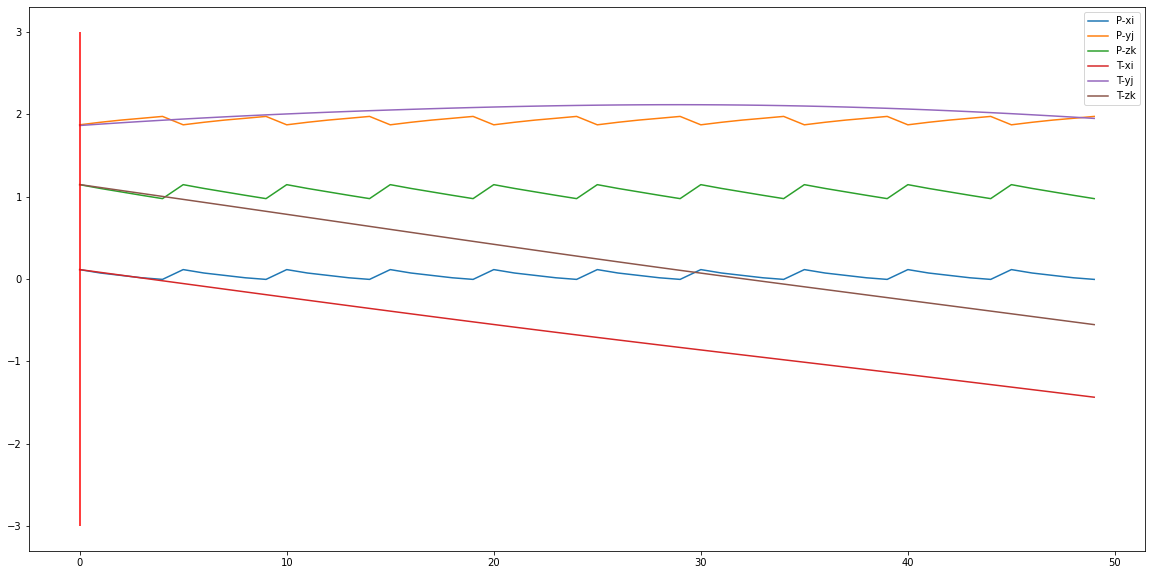

In [ ]:

plt.figure(figsize=(20,10))
plt.plot(pred_position[:,0],label='P-xi')
plt.plot(pred_position[:,1],label='P-yj')
plt.plot(pred_position[:,2],label='P-zk')
# plt.plot(pred_position[:,3],label='P-w')

plt.plot(true_position[:,0],label='T-xi')
plt.plot(true_position[:,1],label='T-yj')
plt.plot(true_position[:,2],label='T-zk')
# plt.plot(true_position[:,3],label='T-w')

plt.vlines(0, -3, 3,color="red")
plt.legend()
# plt.ylim(-0.1,0.1)
plt.show()

In [ ]:
a=np.array([1,2,3])
b=np.array([1,1,3])
np.sqrt(np.sum((a - b) ** 2))

1.0

In [ ]:
import torch
import torch.nn.functional as F

input = torch.nn.Parameter(torch.randn(2,5,3))
print(input[0,1].norm(p=2,dim=0))
x = F.normalize(input, p=2, dim=2, eps=1e-12, out=None)
print(x[0,1].norm(p=2,dim=0))
y = torch.norm(x,dim=1)
print(input)
print(x)
print(y)

tensor(1.1843, grad_fn=<NormBackward1>)
tensor(1.0000, grad_fn=<NormBackward1>)
Parameter containing:
tensor([[[-0.2400,  0.6442,  0.1997],
         [-0.9825, -0.6582, -0.0634],
         [-0.5313, -0.3135,  1.3731],
         [ 1.5563,  0.0836, -0.8920],
         [-0.7368,  0.6919,  2.4265]],

        [[ 0.2720, -0.7545,  0.2331],
         [ 0.0462,  0.7675, -0.7549],
         [-0.2289, -0.8240, -0.3722],
         [-0.3857, -0.1939,  1.1209],
         [-0.0121, -1.8453,  0.8160]]], requires_grad=True)
tensor([[[-0.3352,  0.8999,  0.2790],
         [-0.8296, -0.5558, -0.0536],
         [-0.3529, -0.2083,  0.9122],
         [ 0.8666,  0.0466, -0.4967],
         [-0.2803,  0.2632,  0.9231]],

        [[ 0.3256, -0.9033,  0.2791],
         [ 0.0429,  0.7123, -0.7006],
         [-0.2454, -0.8835, -0.3990],
         [-0.3211, -0.1614,  0.9332],
         [-0.0060, -0.9146,  0.4044]]], grad_fn=<DivBackward0>)
tensor([[1.3247, 1.1107, 1.4183],
        [0.5208, 1.7223, 1.3275]], grad_fn=<CopyBack

In [ ]:
df_raw = pd.read_csv('./dataset/NMP/trimmed_Banana_411.csv')
# cols_data=pre_data(df_raw)
x=np.array(cols_data)[:].reshape(1,-1,7)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
truecolor1='black'
precolor1='blue'
truecolor='red'
precolor='green'


plt.plot(x[0,:,0],label='t-xi',color=truecolor)
plt.plot(x[0,:,1],label='t-yj',color=truecolor)
plt.plot(x[0,:,2],label='t-zk',color=truecolor)
plt.plot(x[0,:,3],label='t-w',color=truecolor)

plt.plot(x[0,:,4],label='t-x',color=truecolor1)
plt.plot(x[0,:,5],label='t-y',color=truecolor1)
plt.plot(x[0,:,6],label='t-z',color=truecolor1)

plt.plot(nx[0,:,0],label='P-xi',color=precolor)
plt.plot(nx[0,:,1],label='P-yj',color=precolor)
plt.plot(nx[0,:,2],label='P-zk',color=precolor)
plt.plot(nx[0,:,3],label='P-w',color=precolor)

plt.plot(nx[0,:,4],label='P-x',color=precolor1)
plt.plot(nx[0,:,5],label='P-y',color=precolor1)
plt.plot(nx[0,:,6],label='P-z',color=precolor1)

plt.vlines(30, -3, 3,color="red")
plt.legend()
# plt.ylim(-0.8,0.8)
plt.show()

ValueError: cannot reshape array of size 536 into shape (1,newaxis,7)

# just XYZ


In [ ]:
from scipy.spatial.transform import Rotation as R
from scipy.ndimage import gaussian_filter1d
def rotate_xyz (data_xyz):
    #轨迹从原点开始
    data_xyz=data_xyz-data_xyz[0]+np.array([0,0,1])
    si=5
    #滤波
    data_xyz[:,0] = gaussian_filter1d(data_xyz[:,0], sigma=si)
    data_xyz[:,1] = gaussian_filter1d(data_xyz[:,1], sigma=si)
    data_xyz[:,2] = gaussian_filter1d(data_xyz[:,2], sigma=si)
    #绕z旋转
    a=np.array([data_xyz[1,0],data_xyz[1,1]])
    b=np.array([1,0])
    cos_ = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    sin_ = np.cross(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    arctan2_ = np.arctan2(sin_, cos_)
    r = R.from_rotvec([0, 0, arctan2_])
    trans_xyz=r.apply(data_xyz)
    return trans_xyz

In [ ]:
df_raw = pd.read_csv('./dataset/NMP/trimmed_Paige_58.csv')
cols_data=df_raw[['x','z','y']].values
cols_data= rotate_xyz(cols_data)
seqlen=30
x=np.array(cols_data)
x=x[:seqlen].reshape(1,seqlen,3)
x=torch.from_numpy(x)
print(x.shape)


torch.Size([1, 30, 3])


In [ ]:
import copy
iter=3
nv=copy.deepcopy(x)
nx=copy.deepcopy(x)
for i in range(iter):  
    prediction=make_prediction(exp, setting,nv)
    nx=np.concatenate((nx,prediction),axis=1)
    nv=torch.from_numpy(nx[:,-seqlen:,:])
nx.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (30x3 and 7x128)

x-lead time [0.28333282]
y-lead time [0.15000153]
z-lead time [0.54166603]


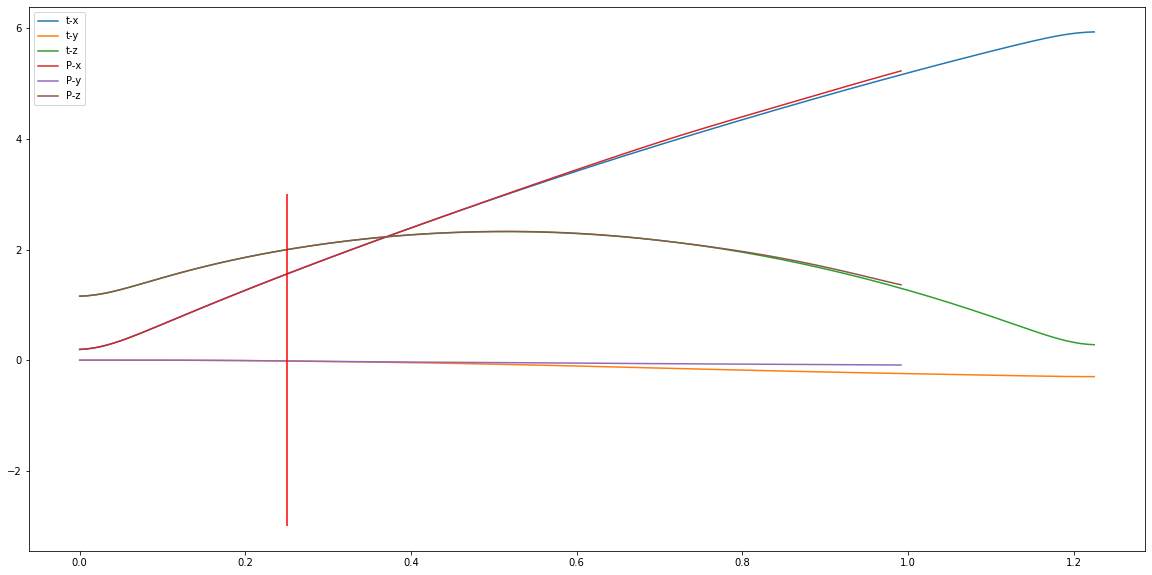

In [ ]:
df_raw = pd.read_csv('./dataset/NMP/trimmed_Paige_18.csv')
cols_data=df_raw[['x','z','y']].values
cols_data= rotate_xyz(cols_data)
seqlen=30
x=np.array(cols_data)
x=x[:seqlen].reshape(1,seqlen,3)
x=torch.from_numpy(x)
import copy
iter=3
nv=copy.deepcopy(x)
nx=copy.deepcopy(x)
for i in range(iter):  
    prediction=make_prediction(exp, setting,nv)
    nx=np.concatenate((nx,prediction),axis=1)
    nv=torch.from_numpy(nx[:,-seqlen:,:])
nx.shape
cols_data=df_raw[['x','z','y']].values
cols_data= rotate_xyz(cols_data)
cols_date=df_raw[['date']].values
cols_date=np.array(cols_date)
x=np.array(cols_data).reshape(1,-1,3)
nx=nx[:,:cols_date.shape[0],:]
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
plt.plot(cols_date,x[0,:,0],label='t-x')
plt.plot(cols_date,x[0,:,1],label='t-y')
plt.plot(cols_date,x[0,:,2],label='t-z')
# plt.plot(x[0,:,3],label='t-w')
# plt.plot(x[0,:,4],label='t-xi')
# plt.plot(x[0,:,5],label='t-yj')
# plt.plot(x[0,:,6],label='t-zk')

plt.plot(cols_date[:nx.shape[1]],nx[0,:,0],label='P-x')
plt.plot(cols_date[:nx.shape[1]],nx[0,:,1],label='P-y')
plt.plot(cols_date[:nx.shape[1]],nx[0,:,2],label='P-z')

for j in range(seqlen,cols_date.shape[0]):
    if abs(x[0,j,0]-nx[0,j,0])>0.01:
        print('x-lead time',cols_date[j]-cols_date[seqlen])
        break
    if j==cols_date.shape[0]-1 and abs(x[0,j,0]-nx[0,j,0])<0.01:
        print('x-lead time',cols_date[j]-cols_date[seqlen])
for j in range(seqlen,cols_date.shape[0]):
    if abs(x[0,j,1]-nx[0,j,1])>0.01:
        print('y-lead time',cols_date[j]-cols_date[seqlen])
        break
for j in range(seqlen,cols_date.shape[0]):
    if abs(x[0,j,2]-nx[0,j,2])>0.01:
        print('z-lead time',cols_date[j]-cols_date[seqlen])
        break
# plt.plot(nx[0,:,3],label='P-w')
# plt.plot(nx[0,:,4],label='P-xi')
# plt.plot(nx[0,:,5],label='P-yj')
# plt.plot(nx[0,:,6],label='P-zk')
plt.vlines(cols_date[seqlen], -3, 3,color="red")
plt.legend()
plt.show()

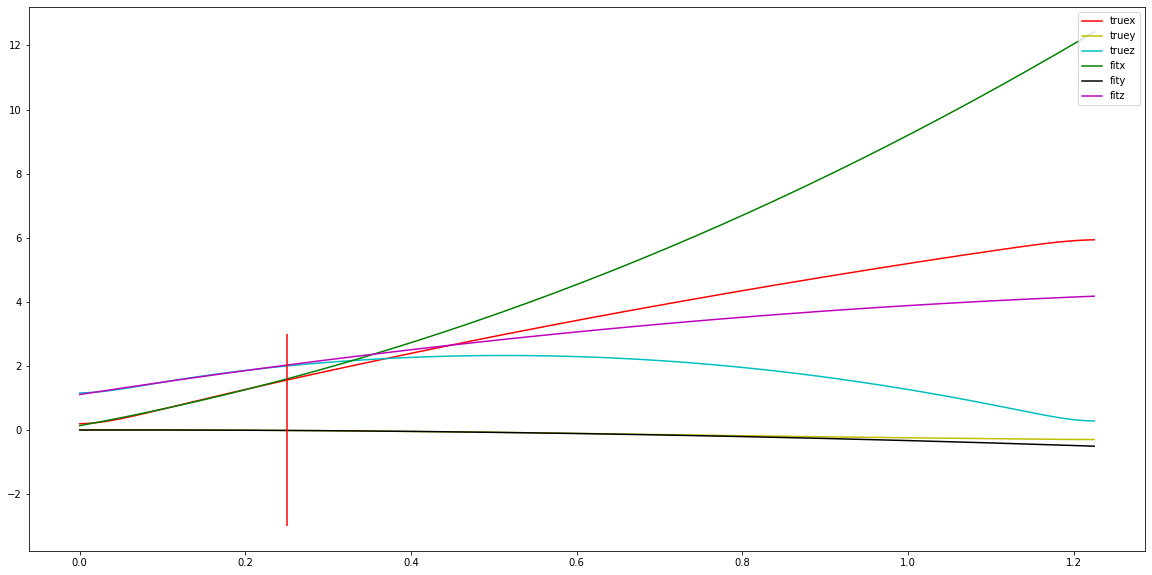

x-lead time [0.]
y-lead time [0.43333435]
z-lead time [0.]


In [ ]:


# print(cols_date[:seqlen].shape)
funcx = np.polyfit(cols_date[:seqlen,0], x[0,:seqlen,0], 2)
yn = np.poly1d(funcx)
valuex=yn(cols_date)
funcy = np.polyfit(cols_date[:seqlen,0], x[0,:seqlen,1], 2)
yn = np.poly1d(funcy)
valuey=yn(cols_date)
funcz = np.polyfit(cols_date[:seqlen,0], x[0,:seqlen,2], 2)
yn = np.poly1d(funcz)
valuez=yn(cols_date)

plt.figure(figsize=(20,10))
plt.plot( cols_date,x[0,:,0], 'r-', label='truex')
plt.plot( cols_date,x[0,:,1], 'y-', label='truey')
plt.plot( cols_date,x[0,:,2], 'c-', label='truez')
# plt.plot( x_nps,x_nps, 'b-', label='input (sin)')
plt.plot( cols_date,valuex, 'g-', label='fitx')
plt.plot( cols_date,valuey, 'k-', label='fity')
plt.plot( cols_date,valuez, 'm-', label='fitz')
# plt.plot( x_nps,y_nps-value, 'y-', label='diff')
plt.legend(loc='upper right')
plt.vlines(cols_date[30], -3, 3,color="red")
plt.show()

for j in range(seqlen,cols_date.shape[0]):
    if abs(x[0,j,0]-valuex[j])>0.01 :
        print('x-lead time',cols_date[j]-cols_date[seqlen])
        break
for j in range(seqlen,cols_date.shape[0]):
    if abs(x[0,j,1]-valuey[j])>0.01 :
        print('y-lead time',cols_date[j]-cols_date[seqlen])
        break
for j in range(seqlen,cols_date.shape[0]) :
    if abs(x[0,j,2]-valuez[j])>0.01 :
        print('z-lead time',cols_date[j]-cols_date[seqlen])
        break

In [ ]:
import copy
filedir='./dataset/NMP/'
Nline_leadtime=[]
fitline_leadtime=[]
for f in os.listdir(filedir)[:500]:  
    df_raw = pd.read_csv(filedir+f)
    cols_data=df_raw[['x','z','y']].values
    cols_data= rotate_xyz(cols_data)
    seqlen=30
    x=np.array(cols_data)
    x=x[:seqlen].reshape(1,seqlen,3)
    x=torch.from_numpy(x)
    iter=4
    nv=copy.deepcopy(x)
    nx=copy.deepcopy(x)
    for i in range(iter):  
        prediction=make_prediction(exp, setting,nv)
        nx=np.concatenate((nx,prediction),axis=1)
        nv=torch.from_numpy(nx[:,-seqlen:,:])
    cols_data=df_raw[['x','z','y']].values
    cols_data= rotate_xyz(cols_data)
    cols_date=df_raw[['date']].values
    cols_date=np.array(cols_date)
    x=np.array(cols_data).reshape(1,-1,3)
    nx=nx[:,:cols_date.shape[0],:]
    for j in range(seqlen,cols_date.shape[0]):
        if abs(x[0,j,0]-nx[0,j,0])>0.01:
            lead_time=cols_date[j]-cols_date[seqlen]
            # print('x-lead time',lead_time)
            Nline_leadtime.append(lead_time)
            break
        if j==cols_date.shape[0]-1 and abs(x[0,j,0]-nx[0,j,0])<0.01:
            lead_time=cols_date[j]-cols_date[seqlen]
            # print('x-lead time',lead_time)
            Nline_leadtime.append(lead_time)
    for j in range(seqlen,cols_date.shape[0]):
        if abs(x[0,j,1]-nx[0,j,1])>0.01:
            lead_time=cols_date[j]-cols_date[seqlen]
            # print('y-lead time',lead_time)
            Nline_leadtime.append(lead_time)
            break
        if j==cols_date.shape[0]-1 and abs(x[0,j,0]-nx[0,j,0])<0.01:
            lead_time=cols_date[j]-cols_date[seqlen]
            # print('y-lead time',lead_time)
            Nline_leadtime.append(lead_time)
    for j in range(seqlen,cols_date.shape[0]):
        if abs(x[0,j,2]-nx[0,j,2])>0.01:
            lead_time=cols_date[j]-cols_date[seqlen]
            # print('z-lead time',lead_time)
            Nline_leadtime.append(lead_time)
            break
    funcx = np.polyfit(cols_date[:seqlen,0], x[0,:seqlen,0], 2)
    yn = np.poly1d(funcx)
    valuex=yn(cols_date)
    funcy = np.polyfit(cols_date[:seqlen,0], x[0,:seqlen,1], 2)
    yn = np.poly1d(funcy)
    valuey=yn(cols_date)
    funcz = np.polyfit(cols_date[:seqlen,0], x[0,:seqlen,2], 2)
    yn = np.poly1d(funcz)
    valuez=yn(cols_date)

    for j in range(seqlen,cols_date.shape[0]):
        if abs(x[0,j,0]-valuex[j])>0.01 :
            lead_time=cols_date[j]-cols_date[seqlen]
            # print('fit-x-lead time',lead_time)
            fitline_leadtime.append(lead_time)
            break
    for j in range(seqlen,cols_date.shape[0]):
        if abs(x[0,j,1]-valuey[j])>0.01 :
            lead_time=cols_date[j]-cols_date[seqlen]
            # print('fit-y-lead time',lead_time)
            fitline_leadtime.append(lead_time)
            break
    for j in range(seqlen,cols_date.shape[0]) :
        if abs(x[0,j,2]-valuez[j])>0.01 :
            lead_time=cols_date[j]-cols_date[seqlen]
            # print('fit-z-lead time',lead_time)
            fitline_leadtime.append(lead_time)
            break

In [ ]:

sum(Nline_leadtime)/len(Nline_leadtime)


array([0.22715689])

In [ ]:
sum(fitline_leadtime)/len(fitline_leadtime)

array([0.06945011])